<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>


В этом домашнем задании стояла задача оттока пользователей телефонной компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если известно, что клиент собирается уйти, то имеет смысл попытаться удержать его, предложив какие-то бонусы. В качестве финальной проверки домашнее задание загружалось на платформу Kaggle (https://www.kaggle.com/c/advanced-dls-spring-2021/).

# Первая часть. Исследование

In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

## Загрузка данных
Перед тем, как работать моделями машинного обучения, необходима предобработка данных. Структурируем данные и проверим, что в них нет нежелательных значений.

Загрузим датасет и разделим признаки на числовые и категориальные:

In [79]:
data = pd.read_csv('./train.csv')

In [80]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols #все фичи
target_col = 'Churn' #значение

Проверим, есть ли в датасете пропущенные данные:

In [81]:
for col in feature_cols:
    print(col, sum(data[col].isna())) #считает количество nan
print('Churn', sum(data['Churn'].isna())) #nan-ов нет, заменять их не надо

ClientPeriod 0
MonthlySpending 0
TotalSpent 0
Sex 0
IsSeniorCitizen 0
HasPartner 0
HasChild 0
HasPhoneService 0
HasMultiplePhoneNumbers 0
HasInternetService 0
HasOnlineSecurityService 0
HasOnlineBackup 0
HasDeviceProtection 0
HasTechSupportAccess 0
HasOnlineTV 0
HasMovieSubscription 0
HasContractPhone 0
IsBillingPaperless 0
PaymentMethod 0
Churn 0


Посмотрим на данные в целом:

In [82]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Видим, что TotalScore имеет тип object, хотя в нем должны быть числовые данные. Если попробуем применить функцию astype(float), получим ошибку. Что делать?

Методом пристального взгляда на данные можно понять, что в этой колонке есть пробелы, которые проверка на NaN выявить не может. Удостоверимся:

In [83]:
data.query("TotalSpent in [' ']")

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Избавимся от них и преобразуем тип

In [84]:
data['TotalSpent'] = data['TotalSpent'].apply(lambda x: x if x !=' ' else 0)
data['TotalSpent'] =data['TotalSpent'].astype(float)

In [85]:
#выведем пять рандомных строчек, чтобы посмотреть на данные и удостовериться, что все хорошо
a = data.shape[0]
strings = np.random.randint(a, size=(5))
data.loc[strings]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3660,1,20.45,20.45,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1647,1,20.00,20.00,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
1069,72,110.65,8065.65,Female,0,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),0
4356,38,20.20,735.90,Female,1,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
3931,2,74.70,165.40,Male,1,No,No,Yes,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,1


## Анализ данных


Построим гистограммы для числинных признаков и посмотрим на их распределение:

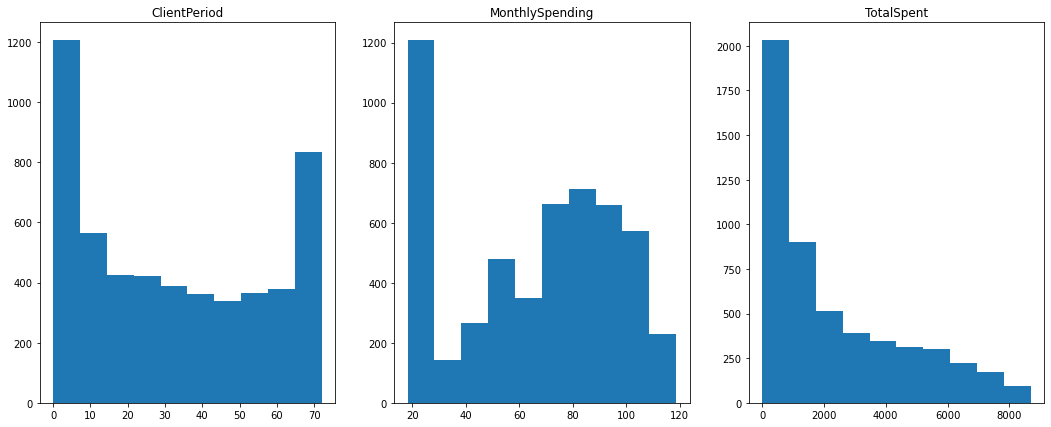

In [86]:
plt.figure(figsize=(18, 7))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    plt.hist(data[col])
    plt.title(label=col)
None

То же самое для категориальных:

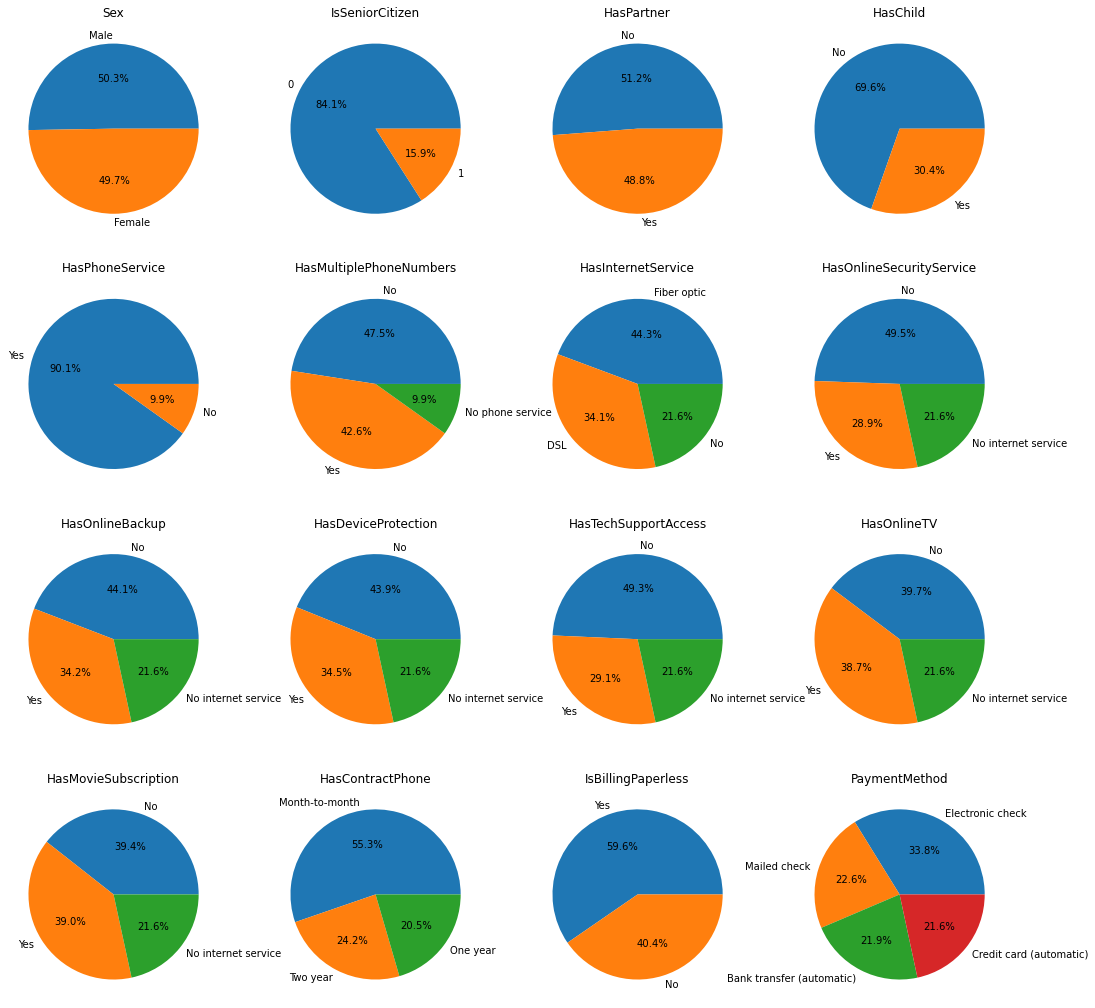

In [87]:
plt.figure(figsize=(18, 18))
for i, col in enumerate(cat_cols):
    plt.subplot(4, 4, i+1)
    plt.pie(data[col].value_counts(), 
            labels=data[col].value_counts().index.tolist(), autopct='%1.1f%%')
    plt.title(label=col)

Посмотрим на распределение целевой переменной. Важно понять, являются ли классы сбалансированными, так как если это не так, нужно быть аккуратным с метрикой. Accuracy не подходит для несбалансированных классов, лучше исппользовать ROC-AUC.

In [88]:
data['Churn'].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

Количество пользователей, которые не вернулись, превышает количество вернувшихся пользователей в три раза, что означает, что классы не являются сбалансированными.

## Применение линейных моделей

In [89]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder

Обработаем данные для того, чтобы к ним можно было применить LogisticRegression: отнормируем числовые признаки, а категориальные закодируем с помощью one-hot-encoding'а. 

In [90]:
#закодируем категориальные данные one-hot-encoding'ом
cat_data = data[cat_cols]
num_data = data[num_cols]
dummy_features = pd.get_dummies(cat_data)
X = pd.concat([num_data, dummy_features], axis=1)
y = data['Churn']
X.head()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55,19.50,1026.35,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.20,0,0,1,0,1,1,0,...,0,0,0,1,1,0,0,1,0,0
2,1,75.90,75.90,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,32,79.30,2570.00,1,1,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
4,60,115.25,6758.45,0,1,0,0,1,0,1,...,1,0,0,1,1,0,0,1,0,0


In [91]:
#переходим к обучению линейной модели и нормировке
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    train_size=0.8,
                                                    random_state=42)
scaler = StandardScaler()
#нормировка
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Первая модель -  LogisticRegression c поиском параметров с помощью GridSearchCV:

In [92]:
clf = LogisticRegression(random_state=0, class_weight="balanced")

# опишем сетку, по которой будем искать
param_grid = {
    'C': [100, 10, 1, 0.1, 0.01, 0.001],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': np.arange(100, 500, 50)
}

# создадим объект GridSearchCV
search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='roc_auc')

# запустим поиск
search.fit(X_train_scaled, y_train)

# выведем наилучшие параметры
print(search.best_params_)
#выведем оценку
print('Train roc_auc:', roc_auc_score(y_train, search.best_estimator_.predict(X_train_scaled)))
print('Test roc_auc:', roc_auc_score(y_test, search.best_estimator_.predict(X_test_scaled)))

{'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Train roc_auc: 0.7691672169697827
Test roc_auc: 0.7515215042343533


Вторая модель - LogisticRegressionCV:

In [93]:
C = [100, 10, 1, 0.1, 0.01, 0.001]
#создадим модель
clf_CV = LogisticRegressionCV(penalty='l2', class_weight='balanced',
                              random_state=0, Cs=C, cv=10, refit=True, scoring='roc_auc')
#обучим ее
clf_CV.fit(X_train_scaled, y_train)
#вытащим точность
scores = clf_CV.scores_[1]
mean_scores = np.mean(scores, axis=0)
i = np.where(mean_scores==np.max(mean_scores))[0][0]
#выведем оценку и параметр
print('C:', C[i])
print('Max train auc_roc:', clf_CV.score(X_train_scaled,y_train),
      '\nMax test auc_roc:', clf_CV.score(X_test_scaled,y_test))

C: 100
Max train auc_roc: 0.8536252171982142 
Max test auc_roc: 0.825601906151587


Лучшее качество дала модель LogisticRegressionCV, параметры: penalty='l2', class_weight='balanced', С = 100

## Применение градиентного бустинга

Градиентный бустинг с дефолтными параметрами часто дает 80% результата за 0% усилий, так что попробуем его применить. Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам. А численные признаки нормировать для моделей, основанных на деревьях не нужно.

In [94]:
!pip install catboost 

Сделаем все необходимое для модели и протестируем ее с стандартными параметрами:

In [95]:
import catboost
X_origin = data.drop('Churn', axis=1) #заведем датафрейм с непреобразованными категориальными признаками
X_train_origin, X_test_origin, y_train, y_test = train_test_split(X_origin, y, 
                                                       train_size=0.8, 
                                                       random_state=42)

boosting_model = catboost.CatBoostClassifier(n_estimators=200, #обучим градиентный бусстинг с стандартными параметрами
                                             silent=True,
                                             cat_features=cat_cols,
                                             eval_metric='AUC')
boosting_model.fit(X_train_origin, y_train)
y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

train_roc = roc_auc_score(y_train, y_train_predicted) #вычислим качество
test_roc = roc_auc_score(y_test, y_test_predicted)
print('Train accuracy:', train_roc)
print('Test accuracy:', test_roc)

Train accuracy: 0.8938600086850297
Test accuracy: 0.8228013224850159


А теперь попробуем подобрать параметры с помощью GridSearch:

In [96]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, silent=True,
                                             cat_features=cat_cols,
                                             eval_metric='AUC')
boosting_model_grid = boosting_model.grid_search({'l2_leaf_reg': np.linspace(0, 1, 20),
                                                  'learning_rate': np.linspace(1, 0.001, 20),
                                                 'depth': [4,5,6],
                                                 'l2_leaf_reg': np.linspace(0, 3, 5)},
                                                 X_train_origin, 
                                                 y_train, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8329523234
bestIteration = 17

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8329523	best: 0.8329523 (0)	total: 7.5s	remaining: 37m 22s

bestTest = 0.8301738268
bestIteration = 10

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8301738	best: 0.8329523 (0)	total: 15.7s	remaining: 38m 58s

bestTest = 0.8285635208
bestIteration = 16

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8285635	best: 0.8329523 (0)	total: 24.4s	remaining: 40m 14s

bestTest = 0.8335058661
bestIteration = 20

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8335059	best: 0.8335059 (3)	total: 31.7s	remaining: 39m 7s

b


bestTest = 0.8366833448
bestIteration = 40

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
33:	loss: 0.8366833	best: 0.8425135 (9)	total: 3m 56s	remaining: 30m 52s

bestTest = 0.8381426846
bestIteration = 85

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
34:	loss: 0.8381427	best: 0.8425135 (9)	total: 4m 3s	remaining: 30m 43s

bestTest = 0.8452704451
bestIteration = 54

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
35:	loss: 0.8452704	best: 0.8452704 (35)	total: 4m 10s	remaining: 30m 34s

bestTest = 0.843667328
bestIteration = 98

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
36:	loss: 0.8436673	best: 0.8452704 (35)	total: 4m 16s	remaining: 


bestTest = 0.8332686335
bestIteration = 32

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
66:	loss: 0.8332686	best: 0.8452704 (35)	total: 7m 23s	remaining: 25m 43s

bestTest = 0.8332290948
bestIteration = 25

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
67:	loss: 0.8332291	best: 0.8452704 (35)	total: 7m 30s	remaining: 25m 37s

bestTest = 0.8386494997
bestIteration = 24

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
68:	loss: 0.8386495	best: 0.8452704 (35)	total: 7m 36s	remaining: 25m 28s

bestTest = 0.8364173568
bestIteration = 18

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
69:	loss: 0.8364174	best: 0.8452704 (35)	total: 7m 42s	remaini


bestTest = 0.8191281343
bestIteration = 141

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
99:	loss: 0.8191281	best: 0.8452704 (35)	total: 11m 29s	remaining: 22m 58s

bestTest = 0.8172338682
bestIteration = 4

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
100:	loss: 0.8172339	best: 0.8452704 (35)	total: 11m 36s	remaining: 22m 52s

bestTest = 0.8231287382
bestIteration = 9

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
101:	loss: 0.8231287	best: 0.8452704 (35)	total: 11m 43s	remaining: 22m 45s

bestTest = 0.8182007706
bestIteration = 4

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
102:	loss: 0.8182008	best: 0.8452704 (35)	total: 11m 50s	re


bestTest = 0.8320716874
bestIteration = 32

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
132:	loss: 0.8320717	best: 0.8452704 (35)	total: 16m 24s	remaining: 20m 36s

bestTest = 0.8345698183
bestIteration = 38

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
133:	loss: 0.8345698	best: 0.8452704 (35)	total: 16m 33s	remaining: 20m 31s

bestTest = 0.8349759892
bestIteration = 41

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
134:	loss: 0.8349760	best: 0.8452704 (35)	total: 16m 42s	remaining: 20m 25s

bestTest = 0.8393791695
bestIteration = 64

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
135:	loss: 0.8393792	best: 0.8452704 (35)	total: 16m 52s


bestTest = 0.8318668047
bestIteration = 27

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
165:	loss: 0.8318668	best: 0.8452704 (35)	total: 21m 15s	remaining: 17m 9s

bestTest = 0.8288942086
bestIteration = 21

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
166:	loss: 0.8288942	best: 0.8452704 (35)	total: 21m 27s	remaining: 17m 5s

bestTest = 0.8318883713
bestIteration = 63

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
167:	loss: 0.8318884	best: 0.8452704 (35)	total: 21m 36s	remaining: 16m 58s

bestTest = 0.8339875201
bestIteration = 26

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
168:	loss: 0.8339875	best: 0.8452704 (35)	total: 21m 47s	r


bestTest = 0.8386099609
bestIteration = 187

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
198:	loss: 0.8386100	best: 0.8452704 (35)	total: 26m 38s	remaining: 13m 31s

bestTest = 0.817938377
bestIteration = 22

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
199:	loss: 0.8179384	best: 0.8452704 (35)	total: 26m 48s	remaining: 13m 24s

bestTest = 0.8094411376
bestIteration = 4

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
200:	loss: 0.8094411	best: 0.8452704 (35)	total: 26m 58s	remaining: 13m 16s

bestTest = 0.8076295434
bestIteration = 8

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
201:	loss: 0.8076295	best: 0.8452704 (35)	total: 27m 7s	re


bestTest = 0.8241279906
bestIteration = 21

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
231:	loss: 0.8241280	best: 0.8452704 (35)	total: 32m 9s	remaining: 9m 25s

bestTest = 0.8291745744
bestIteration = 40

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
232:	loss: 0.8291746	best: 0.8452704 (35)	total: 32m 17s	remaining: 9m 17s

bestTest = 0.8308675523
bestIteration = 24

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
233:	loss: 0.8308676	best: 0.8452704 (35)	total: 32m 26s	remaining: 9m 9s

bestTest = 0.832492236
bestIteration = 51

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
234:	loss: 0.8324922	best: 0.8452704 (35)	total: 32m 35s	remai


bestTest = 0.8180785599
bestIteration = 9

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
264:	loss: 0.8180786	best: 0.8452704 (35)	total: 37m 12s	remaining: 4m 54s

bestTest = 0.8248324994
bestIteration = 5

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
265:	loss: 0.8248325	best: 0.8452704 (35)	total: 37m 22s	remaining: 4m 46s

bestTest = 0.8220000863
bestIteration = 4

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
266:	loss: 0.8220001	best: 0.8452704 (35)	total: 37m 32s	remaining: 4m 38s

bestTest = 0.8260977398
bestIteration = 18

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
267:	loss: 0.8260977	best: 0.8452704 (35)	total: 37m 41s	remai


bestTest = 0.8387824937
bestIteration = 74

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
297:	loss: 0.8387825	best: 0.8452704 (35)	total: 43m 54s	remaining: 17.7s

bestTest = 0.8384913446
bestIteration = 181

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
298:	loss: 0.8384913	best: 0.8452704 (35)	total: 44m 8s	remaining: 8.86s

bestTest = 0.8303032264
bestIteration = 34

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
299:	loss: 0.8303032	best: 0.8452704 (35)	total: 44m 16s	remaining: 0us
Estimating final quality...


Выведем лучшие параметры для catboost

In [97]:
print(boosting_model_grid['params'])

{'depth': 4, 'learning_rate': 0.21131578947368423, 'l2_leaf_reg': 0.75}


Посмотрим на точность:

In [98]:
y_train_best = boosting_model.predict_proba(X_train_origin)[:, 1] #посмотрим на точность
y_test_best = boosting_model.predict_proba(X_test_origin)[:, 1]

train_auc_best = roc_auc_score(y_train, y_train_best)
test_auc_best = roc_auc_score(y_test, y_test_best)
print ('Max auc_roc train:', train_auc_best)
print('Max auc_roc test', test_auc_best)

Max auc_roc train: 0.9000428743621749
Max auc_roc test 0.819326566987745


Лучшее качество дала модель CatBoostClassifier с параметрами 'depth': 4, 'learning_rate': 0.21131578947368423, 'l2_leaf_reg': 0.75, которые были подобраны поиском по сетке

# Предсказания

Лучшей моделью оказался, что неудивительно, градиентный бустинг. Применим его и запишем файл с ответами на тестовой выборке.

In [99]:
best_model = boosting_model

In [100]:
#считываем тестовые данные и применяем к ним модель
X_test = pd.read_csv('./test.csv')
pred = pd.Series(best_model.predict_proba(X_test)[:, 1])
submission = pd.DataFrame({'Id': np.arange(0, len(pred)), 'Churn': pred})

#сохраняем файл с ответами
submission.to_csv('./my_submission.csv',index=None)

# Результаты
Мой ник на Kaggle: Margarita_Chudova. 
Попытка #2, score: 0.84435
